# **The Natural Experiment**

In 2017, CAHOOTS expanded service hours between 3:00 AM and 10:00 AM. To measure the divertibility of each call type we utilize the increase over baseline following the service hour expansion.

### Data Cleaning

In [257]:
# Import data
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text  
import numpy as np
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
plt.rcParams['figure.dpi'] = 300

file_path = r'D:\dsci\CAHOOTS\Data\call_data_from_CAD.csv'
CAD_data = pd.read_csv(file_path)

In [258]:
# Standardize Cahoots identifiers 
cahoots_identifiers = r"1J77\s*|3J79\s*|3J78\s*|3J77\s*|4J79\s*|3J81\s*|3J76\s*|2J28\s*|2J29\s*|CAHOOT\s*|CAHOT\s*|CAHO\s*"
CAD_data["PrimaryUnitCallSign"] = CAD_data["PrimaryUnitCallSign"].replace(cahoots_identifiers, 'CAHOOT', regex=True)
CAD_data["RespondingUnitCallSign"] = CAD_data["RespondingUnitCallSign"].replace(cahoots_identifiers, 'CAHOOT', regex=True)

# Create an identifier for Cahoots involvement 
CAD_data['Cahoots_related'] = ((CAD_data['PrimaryUnitCallSign'] == 'CAHOOT') | (CAD_data['RespondingUnitCallSign'] == 'CAHOOT')).astype(int)
CAD_data.loc[:, "cahoots_handled"] = (CAD_data["Cahoots_related"] == 1) & (CAD_data["IsPrimary"] == 1)

# Manage dt
CAD_data["Call_Created_Time"] = pd.to_datetime(CAD_data['Call_Created_Time'], errors='coerce')
CAD_data["Unit_Dispatched_Time"] = pd.to_datetime(CAD_data['Unit_Dispatched_Time'], errors='coerce')
CAD_data["Unit_OnScene_Time"] = pd.to_datetime(CAD_data['Unit_OnScene_Time'], errors='coerce')

# Drop unneeded cols
CAD_data = CAD_data.drop(columns=['Unnamed: 0', 'Beat', 'Unit_Cleared_Time'])

# Create hr and year cols
CAD_data["year"] = CAD_data["Unit_Dispatched_Time"].dt.year
CAD_data["hr"] = CAD_data["Unit_Dispatched_Time"].dt.hour
CAD_data.dropna(subset="hr", inplace=True)

In [259]:
# Drop non-public CFS
CAD_data = CAD_data[CAD_data["Call_Source"] != "SELF"]
CAD_data = CAD_data[CAD_data["Call_Source"] != "RPTO"]

# (Gone on arrival has been removed as a filter but you can turn it on to replicate the paper's exact numbers)
#CAD_data = CAD_data[CAD_data["Disposition"] != "GONE ON ARRIVAL"]

# Drop duplicates and NA
CAD_data = CAD_data.drop_duplicates()
CAD_data = CAD_data.dropna(subset=["PrimaryUnitCallSign"], how='all')

# Only include calls in Eugene 
zip_codes = [97402.0, 97401.0, 97405.0, 97404.0, 97403.0, 97408.0]
CAD_data = CAD_data[CAD_data['Call_Zipcode'].isin(zip_codes)]

# Remove 2022 and 2023 until data errors can be fixed
CAD_data = CAD_data[~CAD_data["year"].isin([2022.0, 2023.0, 2024.0])]

# Rename for clarity
CAD_data['InitialIncidentTypeDescription'] = CAD_data['InitialIncidentTypeDescription'].replace("ASSIST PUBLIC- POLICE", "ASSIST PUBLIC")

In [260]:
# Marked for future import factoring 

def filter_df_by_time(df, start_time=None, end_time=None, time_column='Unit_Dispatched_Time'):
    """
    Filters the dataframe based on the time range specified by the user

    Parameters:
    df to filter
    start_time (str)
    end_time (str)
    time_column (str): The name of the column containing datetime values

    """
    df.loc[:, time_column] = pd.to_datetime(df[time_column])

    if start_time:
        if len(start_time) == 4:  # if only a year is given
            start_time = pd.to_datetime(f"{start_time}-01-01")
    else:
        start_time = df[time_column].min() 

    if end_time:
        if len(end_time) == 4:  
            end_time = pd.to_datetime(f"{end_time}-12-31 23:59:59")
    else:
        end_time = df[time_column].max()  

    filtered_df = df[(df[time_column] >= start_time) & (df[time_column] <= end_time)]

    return filtered_df

def dataset_builder(data, dispatched=False, arrived=False, solo_cahoots=False, time=None):
    # Apply time range if specified
    if time:
        data = filter_df_by_time(data, time[0], time[1], time[2])
    
    # Dispatched filter is based on "Unit_Dispatched_Time"
    if dispatched:
        data = data[data["Unit_Dispatched_Time"].notna()]
    
    # Arrived filter is based on "Call_First_Dispatched_Time"
    if arrived:
        data = data[data["Unit_OnScene_Time"].notna()]
        data = data[data["Unit_Dispatched_Time"].notna()]
        
    # Only Include CAHOOTS calls where no other agencies are involved
    if solo_cahoots:
        data = data[~((data['PrimaryUnitCallSign'] == 'CAHOOTS') & (data['IsPrimary'] == 0))]
        
    return data

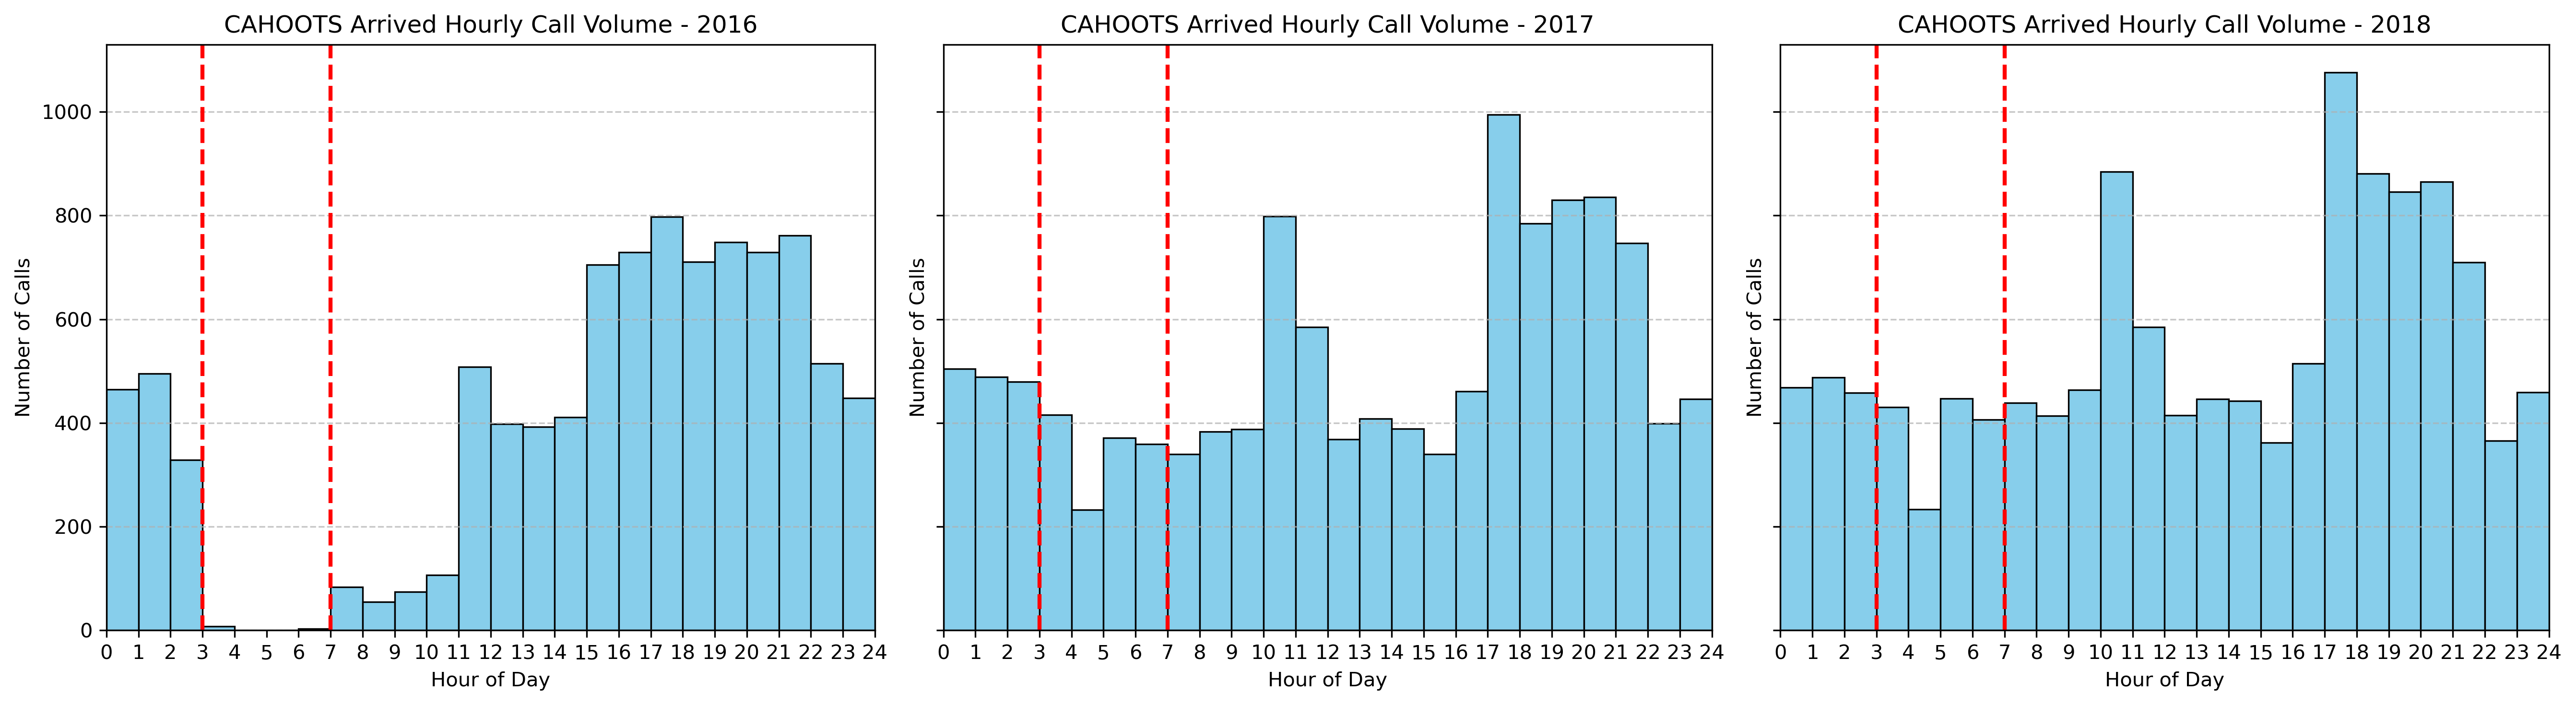

In [261]:
def plot_cahoots_hourly_call_volume(
    CAD_data,
    years,
    title_template='CAHOOTS Hourly Call Volume - {year}',
    nrows=1,
    ncols=None,
    figsize=(18, 5),
    filter_primary=True,
    filter_cahoots_related=True
):
    """
    Plots the hourly call volume for the specified years.

    Parameters:
    - CAD_data: DataFrame containing the CAD data.
    - years: Iterable of years to include in the plot.
    - title_template: Template for subplot titles. Default is 'CAHOOTS Hourly Call Volume - {year}'.
    - nrows: Number of subplot rows. Default is 1.
    - ncols: Number of subplot columns. If None, it defaults to the number of years.
    - figsize: Tuple specifying the figure size. Default is (18, 5).
    - filter_primary: Boolean to filter data to only include primary calls. Default is True.
    - filter_cahoots_related: Boolean to filter data to only include CAHOOTS-related calls. Default is True.
    """
    # Create a dictionary to hold dataframes for each year
    calls_by_hr = {}

    # Iterate through each year and build the dataset and hourly call volume
    for year in years:
        # Build the dataset for the specified year
        CAD_year = dataset_builder(
            CAD_data,
            dispatched=True,
            arrived=True,
            time=[str(year), str(year), 'Unit_Dispatched_Time']
        )

        # Start with all True (no filter)
        filter_condition = pd.Series(True, index=CAD_year.index)

        # Apply filters based on parameters
        if filter_cahoots_related:
            filter_condition &= (CAD_year["Cahoots_related"] == 1)
        if filter_primary:
            filter_condition &= (CAD_year["IsPrimary"] == 1)

        # Filter the data
        filtered_data = CAD_year[filter_condition]

        # Group by hour
        calls_by_hr[year] = (
            filtered_data
            .groupby('hr')
            .size()
            .reindex(range(24), fill_value=0)  # Ensure every hour is represented
            .reset_index(name='count')
        )

    # Determine number of subplots
    n_plots = len(years)
    if ncols is None:
        ncols = n_plots

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=True)

    # Ensure axes is iterable
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Plot each year in its corresponding subplot
    for ax, (year, df) in zip(axes, calls_by_hr.items()):
        # Align bars to start at the hour tick
        ax.bar(
            df['hr'],
            df['count'],
            color='skyblue',
            align='edge',
            width=1,
            edgecolor='black',
            linewidth=0.8
        )
        ax.set_title(title_template.format(year=year))
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Number of Calls')
        ax.set_xticks(range(25))  # Set x-ticks at each hour mark from 0 to 24
        ax.set_xlim(0, 24)
        ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability

        # Add dashed vertical lines from 3am (3) to 10am (10)
        ax.axvline(x=3, color='red', linestyle='--', linewidth=2, alpha=1)
        ax.axvline(x=7, color='red', linestyle='--', linewidth=2, alpha=1)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

plot_cahoots_hourly_call_volume(
    CAD_data,
    years=range(2016, 2019),
    title_template='CAHOOTS Arrived Hourly Call Volume - {year}',
    nrows=1,
    ncols=3,
    figsize=(18, 5),
    filter_primary=True,           
    filter_cahoots_related=True    
)

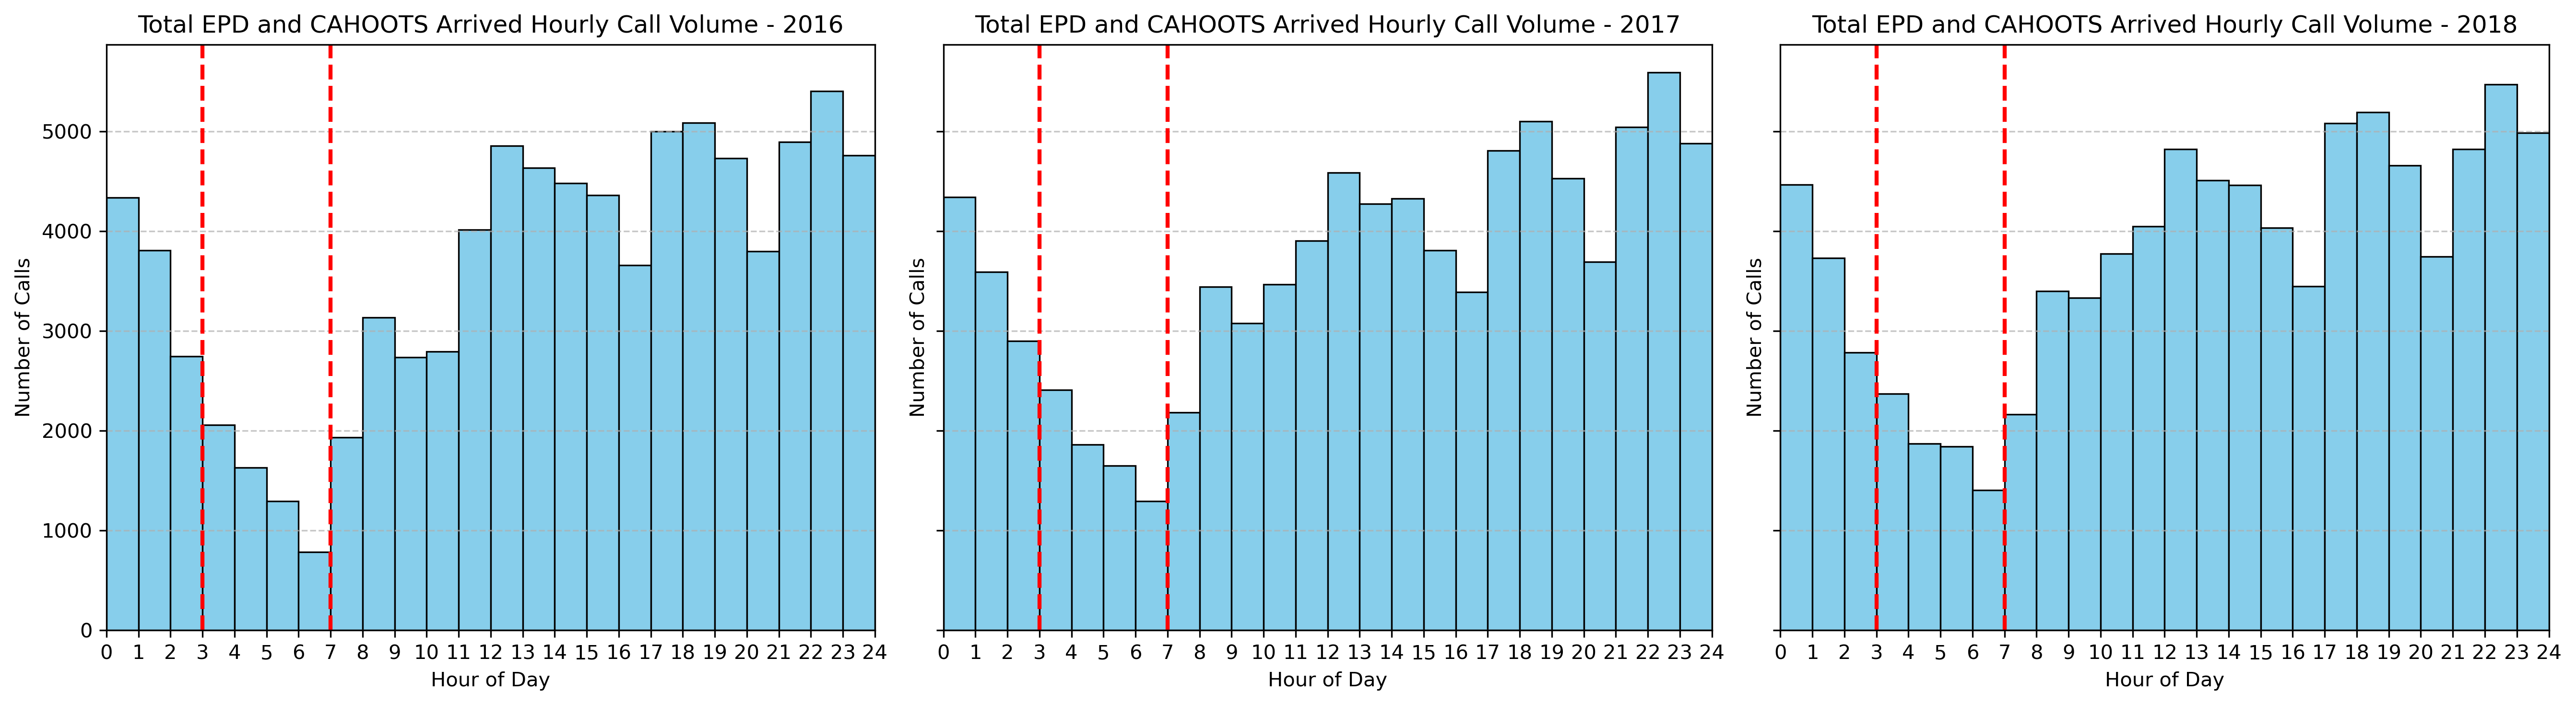

In [262]:
plot_cahoots_hourly_call_volume(
    CAD_data,
    years=range(2016, 2019),
    title_template='Total EPD and CAHOOTS Arrived Hourly Call Volume - {year}',
    filter_primary=False,
    filter_cahoots_related=False
)

# Total Call volume for top CAHOOTS Incident types by hour - 2016-2021

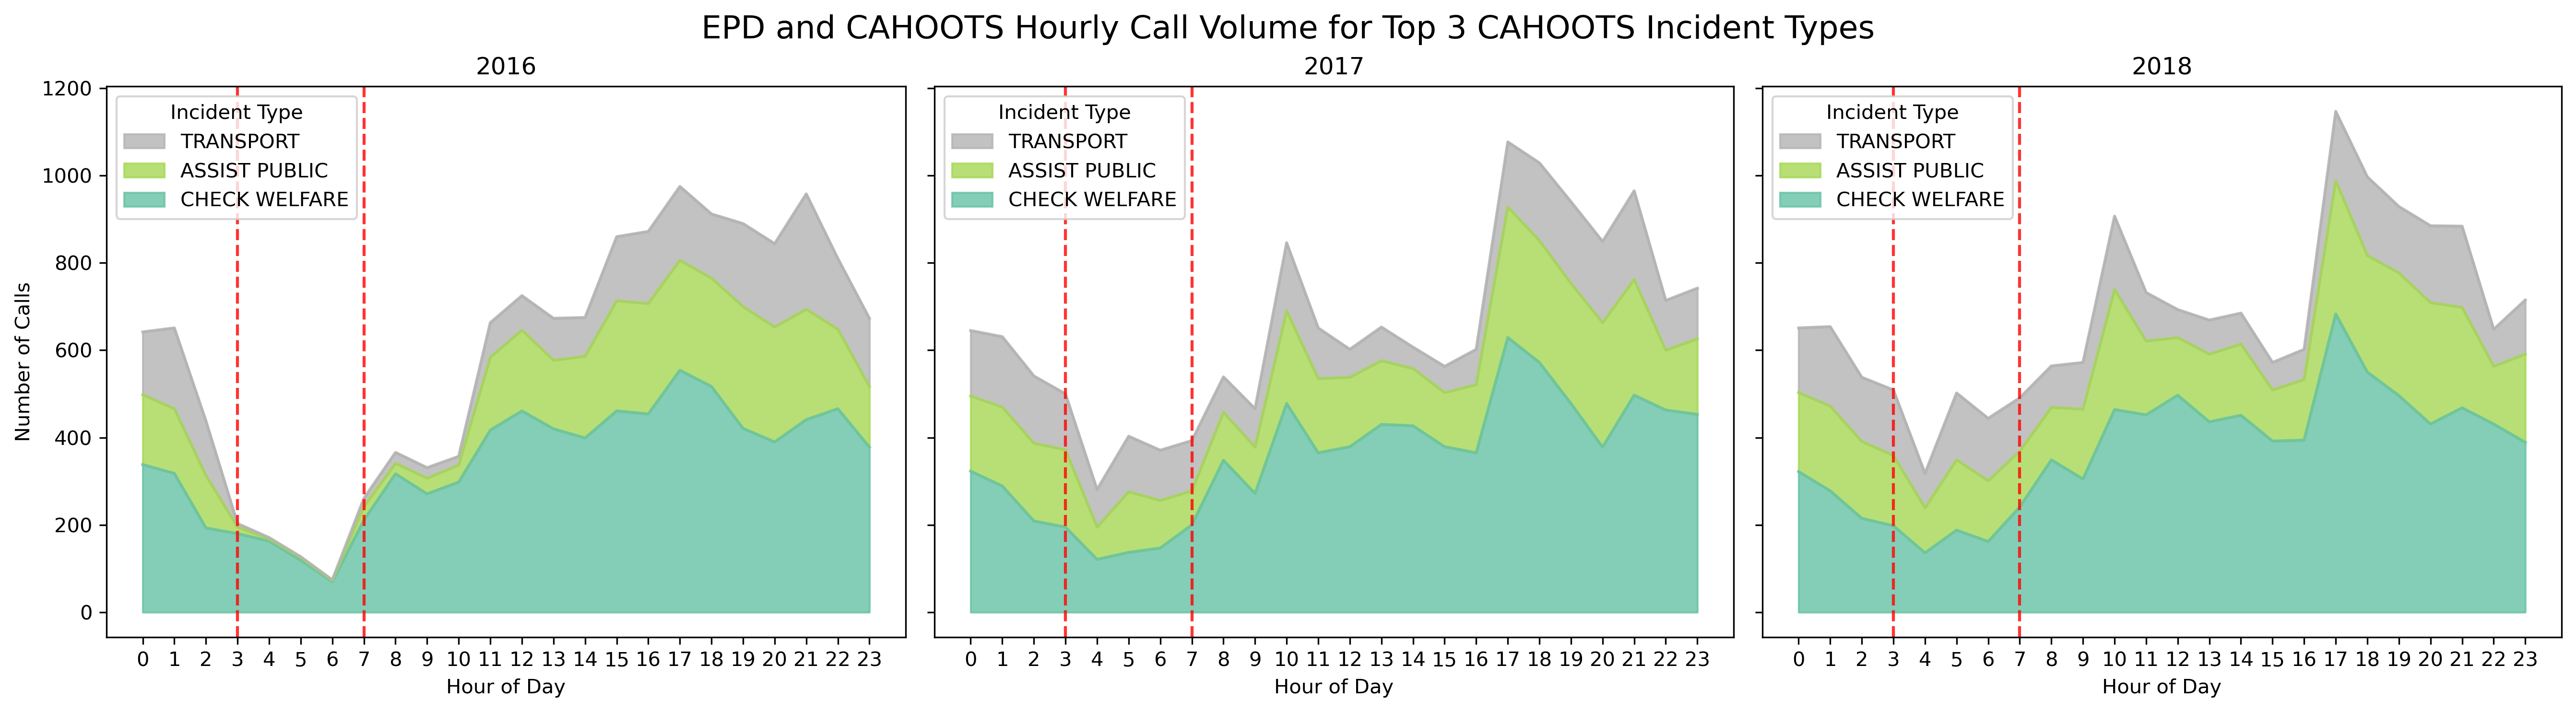

In [263]:
def plot_stacked_area_top_incidents(data, year_range, top_n_incidents=5):
    """
    Plot stacked area plots of hourly call volumes for the top N incident types over a range of years.

    Parameters:
    data: (df)
    year_range (tuple): A tuple specifying the range of years to include, e.g., (2016, 2021)
    top_n_incidents (int): The number of top incident types to include in the plot.

    """
    # Identify the top N most frequent CAHOOTS-related call types and their counts
    top_incident_counts = (
        data[data["Cahoots_related"] == 1]
        .groupby("InitialIncidentTypeDescription")
        .size()
        .nlargest(top_n_incidents)
    )

    top_incident_types = top_incident_counts.index.tolist()

    # Create a dataframe to hold all hourly call volumes for the top N incident types
    area_data = []

    # Iterate through each year and each incident type to collect data
    for year in range(year_range[0], year_range[1] + 1):
        # Filter data for the current year
        data_year = data[data['Call_Created_Time'].dt.year == year]

        # For each of the top N incident types, collect hourly call volume data
        for incident_type in top_incident_types:
            # Filter data for the specific incident type
            filtered_data = data_year[data_year["InitialIncidentTypeDescription"] == incident_type]

            # Group by hour and calculate the hourly volume
            hourly_volume = (
                filtered_data.groupby("hr")
                .size()
                .reindex(range(24), fill_value=0)  # Ensure every hour is represented
                .reset_index(name='count')
            )

            # Store the data in a list for creating a dataframe later
            for hr, count in zip(hourly_volume['hr'], hourly_volume['count']):
                area_data.append([year, incident_type, hr, count])

    area_df = pd.DataFrame(area_data, columns=['Year', 'Incident Type', 'Hour', 'Call Volume'])

    # Pivot the data to create a stacked area plot
    pivot_df = area_df.pivot_table(values='Call Volume', index='Hour', columns=['Year', 'Incident Type'], fill_value=0)

    # Create a stacked area plot for each year
    num_years = year_range[1] - year_range[0] + 1
    nrows = (num_years + 2) // 3  # Calculate number of rows needed for subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharey=True)
    axes = axes.flatten() 

    # Plot a stacked area plot for each year
    for ax, year in zip(axes, range(year_range[0], year_range[1] + 1)):
        # Extract the data for the current year
        if year in pivot_df.columns.levels[0]:
            year_data = pivot_df[year]
            
            # Rearrange the columns of year_data according to 'top_incident_types' order
            # Select only the incident types present in 'year_data' and reindex
            incident_types_in_year = [it for it in top_incident_types if it in year_data.columns]
            year_data = year_data.reindex(columns=incident_types_in_year)
            
            # Plot a stacked area plot for the top N incident types
            year_data.plot(kind='area', stacked=True, ax=ax, cmap='Set2', alpha=0.8)
            
            # Reverse the legend entries to match the visual stacking order
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles[::-1], labels[::-1], title='Incident Type', loc='upper left')
            
            ax.set_title(f'{year}')
            ax.set_xlabel('Hour of Day')
            ax.set_ylabel('Number of Calls')
            ax.set_xticks(range(24))  # Ensure all hours (0-23) are shown on the x-axis
            ax.grid(False)

            # Draw dashed vertical lines 
            ax.axvline(x=3, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
            ax.axvline(x=7, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
        else:
            ax.set_visible(False)

    # Hide any remaining unused subplots if year range is smaller than subplot grid
    for i in range(num_years, len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(f'EPD and CAHOOTS Hourly Call Volume for Top {top_n_incidents} CAHOOTS Incident Types', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.70])
    plt.subplots_adjust(top=0.88) 
    
    plt.show()

plot_stacked_area_top_incidents(dataset_builder(CAD_data, dispatched=True, arrived=True, time=[str(2016), str(2018), 'Call_First_Dispatched_Time']), year_range=(2016, 2021), top_n_incidents=3)

### Fisher's Exact Test Per Call Type 3am - 6am

In [264]:
# Fisher's exact test, correcting for multiple comparisons
def analyze_period(filtered_data, pre_year, post_year, min_count=0):
    # Segment Data into Pre-Expansion and Post-Expansion Periods
    pre_expansion = filtered_data[filtered_data['year'] == pre_year]
    post_expansion = filtered_data[filtered_data['year'] == post_year]
    
    # Calculate Total Calls in Pre and Post Periods
    total_pre_calls = pre_expansion.shape[0]
    total_post_calls = post_expansion.shape[0]
    
    # Pre-Expansion
    pre_calls = pre_expansion.groupby('InitialIncidentTypeDescription').size().reset_index(name='pre_call_count')
    
    # Post-Expansion
    post_calls = post_expansion.groupby('InitialIncidentTypeDescription').size().reset_index(name='post_call_count')
    
    # Merge Pre and Post DataFrames
    call_volume_comparison = pd.merge(pre_calls, post_calls, on='InitialIncidentTypeDescription', how='left').fillna(0)
    
    # Compute Absolute Changes
    call_volume_comparison['absolute_change'] = call_volume_comparison['post_call_count'] - call_volume_comparison['pre_call_count']
    
    # Calculate divertible prop
    call_volume_comparison['percentage_divertible'] = (call_volume_comparison['pre_call_count'] / (call_volume_comparison['post_call_count'])) * 100
    
    # Replace infinite values resulting from division by zero with NaN
    call_volume_comparison.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Exclude Call Types with Low Counts & Define minimum count threshold
    call_volume_comparison = call_volume_comparison[
        (call_volume_comparison['pre_call_count'] >= min_count) &
        (call_volume_comparison['post_call_count'] >= min_count)
    ]
    
    # Significance Testing using Fisher's Exact Test
    statistical_results = []
    contingency_tables = []
    call_types = []
    
    for index, row in call_volume_comparison.iterrows():
        # Counts of the specific call type
        call_type_pre = row['pre_call_count']
        call_type_post = row['post_call_count']
        
        # Counts of all other call types
        other_calls_pre = total_pre_calls - call_type_pre
        other_calls_post = total_post_calls - call_type_post

        # Build the contingency table
        contingency_table = np.array([
            [call_type_pre, other_calls_pre],
            [call_type_post, other_calls_post]
        ])
        
        # Append to lists
        contingency_tables.append(contingency_table)
        call_types.append(row['InitialIncidentTypeDescription'])
    
    # Perform Fisher's Exact Test and collect p-values
    p_values = []
    for table in contingency_tables:
        if np.any(table < 0):
            p_value = np.nan
        else:
            _, p_value = fisher_exact(table, alternative='two-sided')
        p_values.append(p_value)
    
    # Apply multiple comparisons correction using Benjamini-Hochberg
    p_values = np.array(p_values)
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')
    
    # Create a DataFrame with Statistical Results
    stats_df = pd.DataFrame({
        'InitialIncidentTypeDescription': call_types,
        'p_value': p_values,
        'p_value_corrected': pvals_corrected,
        'significant': reject
    })
    
    # Merge with the call_volume_comparison DataFrame
    call_volume_comparison = pd.merge(call_volume_comparison, stats_df, on='InitialIncidentTypeDescription')
    
    # Filter post-expansion data for CAHOOTS-handled calls
    cahoots_calls = post_expansion[post_expansion['cahoots_handled'] == True]
    
    # Count CAHOOTS calls by Call Type
    cahoots_call_counts = cahoots_calls.groupby('InitialIncidentTypeDescription').size().reset_index(name='cahoots_call_count')
    
    # Merge with call_volume_comparison DataFrame
    call_volume_comparison = pd.merge(call_volume_comparison, cahoots_call_counts, on='InitialIncidentTypeDescription', how='left').fillna(0)
    
    # Calculate the proportion of CAHOOTS-handled calls
    call_volume_comparison['cahoots_proportion'] = (call_volume_comparison['cahoots_call_count'] / call_volume_comparison['post_call_count'].replace(0, np.nan)) * 100
    
    # Classify Call Types Based on Divertibility
    conditions = [
        (call_volume_comparison['significant'] == False),  # No significant change
        (call_volume_comparison['significant'] == True) & (call_volume_comparison['absolute_change'] > 0),  # Significant increase
        (call_volume_comparison['significant'] == True) & (call_volume_comparison['absolute_change'] < 0)  # Significant decrease
    ]
    categories = ['No significant change', 'Significant increase', 'Significant decrease']
    
    # Create a new column for classification
    call_volume_comparison['divertibility_classification'] = np.select(conditions, categories, default='No Data')
    
    # Calculate Total Calls for Sorting and Selection
    call_volume_comparison['total_calls'] = call_volume_comparison['pre_call_count'] + call_volume_comparison['post_call_count']
    
    return call_volume_comparison

In [265]:
def visualize_calls(call_volume_comparison, top_n=100, label_threshold=300, title='Pre vs Post Expansion Call Counts for Top Incident Types'):
    # Select the Top 'top_n' Incident Types by Total Calls
    top_incidents = call_volume_comparison.nlargest(top_n, 'total_calls').copy()

    # Assign colors based on statistical significance of increase or decrease
    def determine_color(row):
        if row['significant'] and row['absolute_change'] > 0:
            return 'seagreen'  # Significant Increase
        elif row['significant'] and row['absolute_change'] < 0:
            return 'indianred'  # Significant Decrease
        else:
            return 'grey'  # No Significant Change

    top_incidents['color'] = top_incidents.apply(determine_color, axis=1)

    # Create Scatter Plot
    plt.figure(figsize=(16, 10)) 
    scatter = sns.scatterplot(
        data=top_incidents,
        x='pre_call_count',
        y='post_call_count',
        hue='color',  
        s=100,  
        palette={'seagreen': 'seagreen', 'indianred': 'indianred', 'grey': 'grey'},
        edgecolor='black',
        alpha=0.7,
        legend=False  
    )

    # Add Reference Line 
    max_val = max(top_incidents['pre_call_count'].max(), top_incidents['post_call_count'].max()) * 1.05  # Add 5% buffer
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

    # Labels and Title
    plt.xlabel('Pre-Expansion Call Count', fontsize=14)
    plt.ylabel('Post-Expansion Call Count', fontsize=14)
    plt.title(title, fontsize=16)

    # Annotate Points 
    label_mode = 'call_count'  # Options: 'top_n' or 'call_count'
    texts = []  

    # Store the original positions and texts for later use
    positions = []
    for idx, row in top_incidents.iterrows():
        if label_mode == 'top_n' or (label_mode == 'call_count' and row['total_calls'] >= label_threshold):
            # Create text annotation without arrows
            text = plt.text(
                row['pre_call_count'], row['post_call_count'],
                row['InitialIncidentTypeDescription'],
                fontsize=9,
                ha='left',  
                va='center',
                bbox=dict(facecolor='white', alpha=1, edgecolor='black', pad=2)
            )
            texts.append(text)
            positions.append((row['pre_call_count'], row['post_call_count']))

    # Adjust text labels 
    adjust_text(
        texts,
        only_move={'texts': 'xy'},
        expand_text=(1.2, 1.2),
        force_text=(0.5, 0.5),
        lim=1000
    )

    # Manually draw arrows from the points to the text labels
    for pos, text in zip(positions, texts):
        start_x, start_y = pos
        end_x, end_y = text.get_position()
        # Only draw an arrow if the text has moved significantly
        if np.hypot(end_x - start_x, end_y - start_y) > 0.01:
            arrow = plt.Arrow(
                start_x, start_y,
                end_x - start_x, end_y - start_y,
                width=0.1,
                color='black',
                zorder=2  # Draw behind the text
            )
            plt.gca().add_patch(arrow)

    # custom legend handles for color 
    color_legend_elements = [
        Patch(facecolor='seagreen', edgecolor='seagreen', label='Significant Increase'),
        Patch(facecolor='indianred', edgecolor='indianred', label='Significant Decrease'),
        Patch(facecolor='grey', edgecolor='grey', label='No Significant Change')
    ]

    # Create the legend
    plt.legend(handles=color_legend_elements, title='Statistical Significance',
               fontsize=12, title_fontsize=12, loc='center left', bbox_to_anchor=(0.82, 0.13))

    plt.subplots_adjust(right=1) 
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [266]:
# Create dataset
filtered_data = dataset_builder(CAD_data, dispatched=True, arrived=True, time=[str(2016), str(2018), 'Unit_Dispatched_Time'])
filtered_data = filtered_data[(filtered_data['hr'] >= 3) & (filtered_data['hr'] <= 6)]

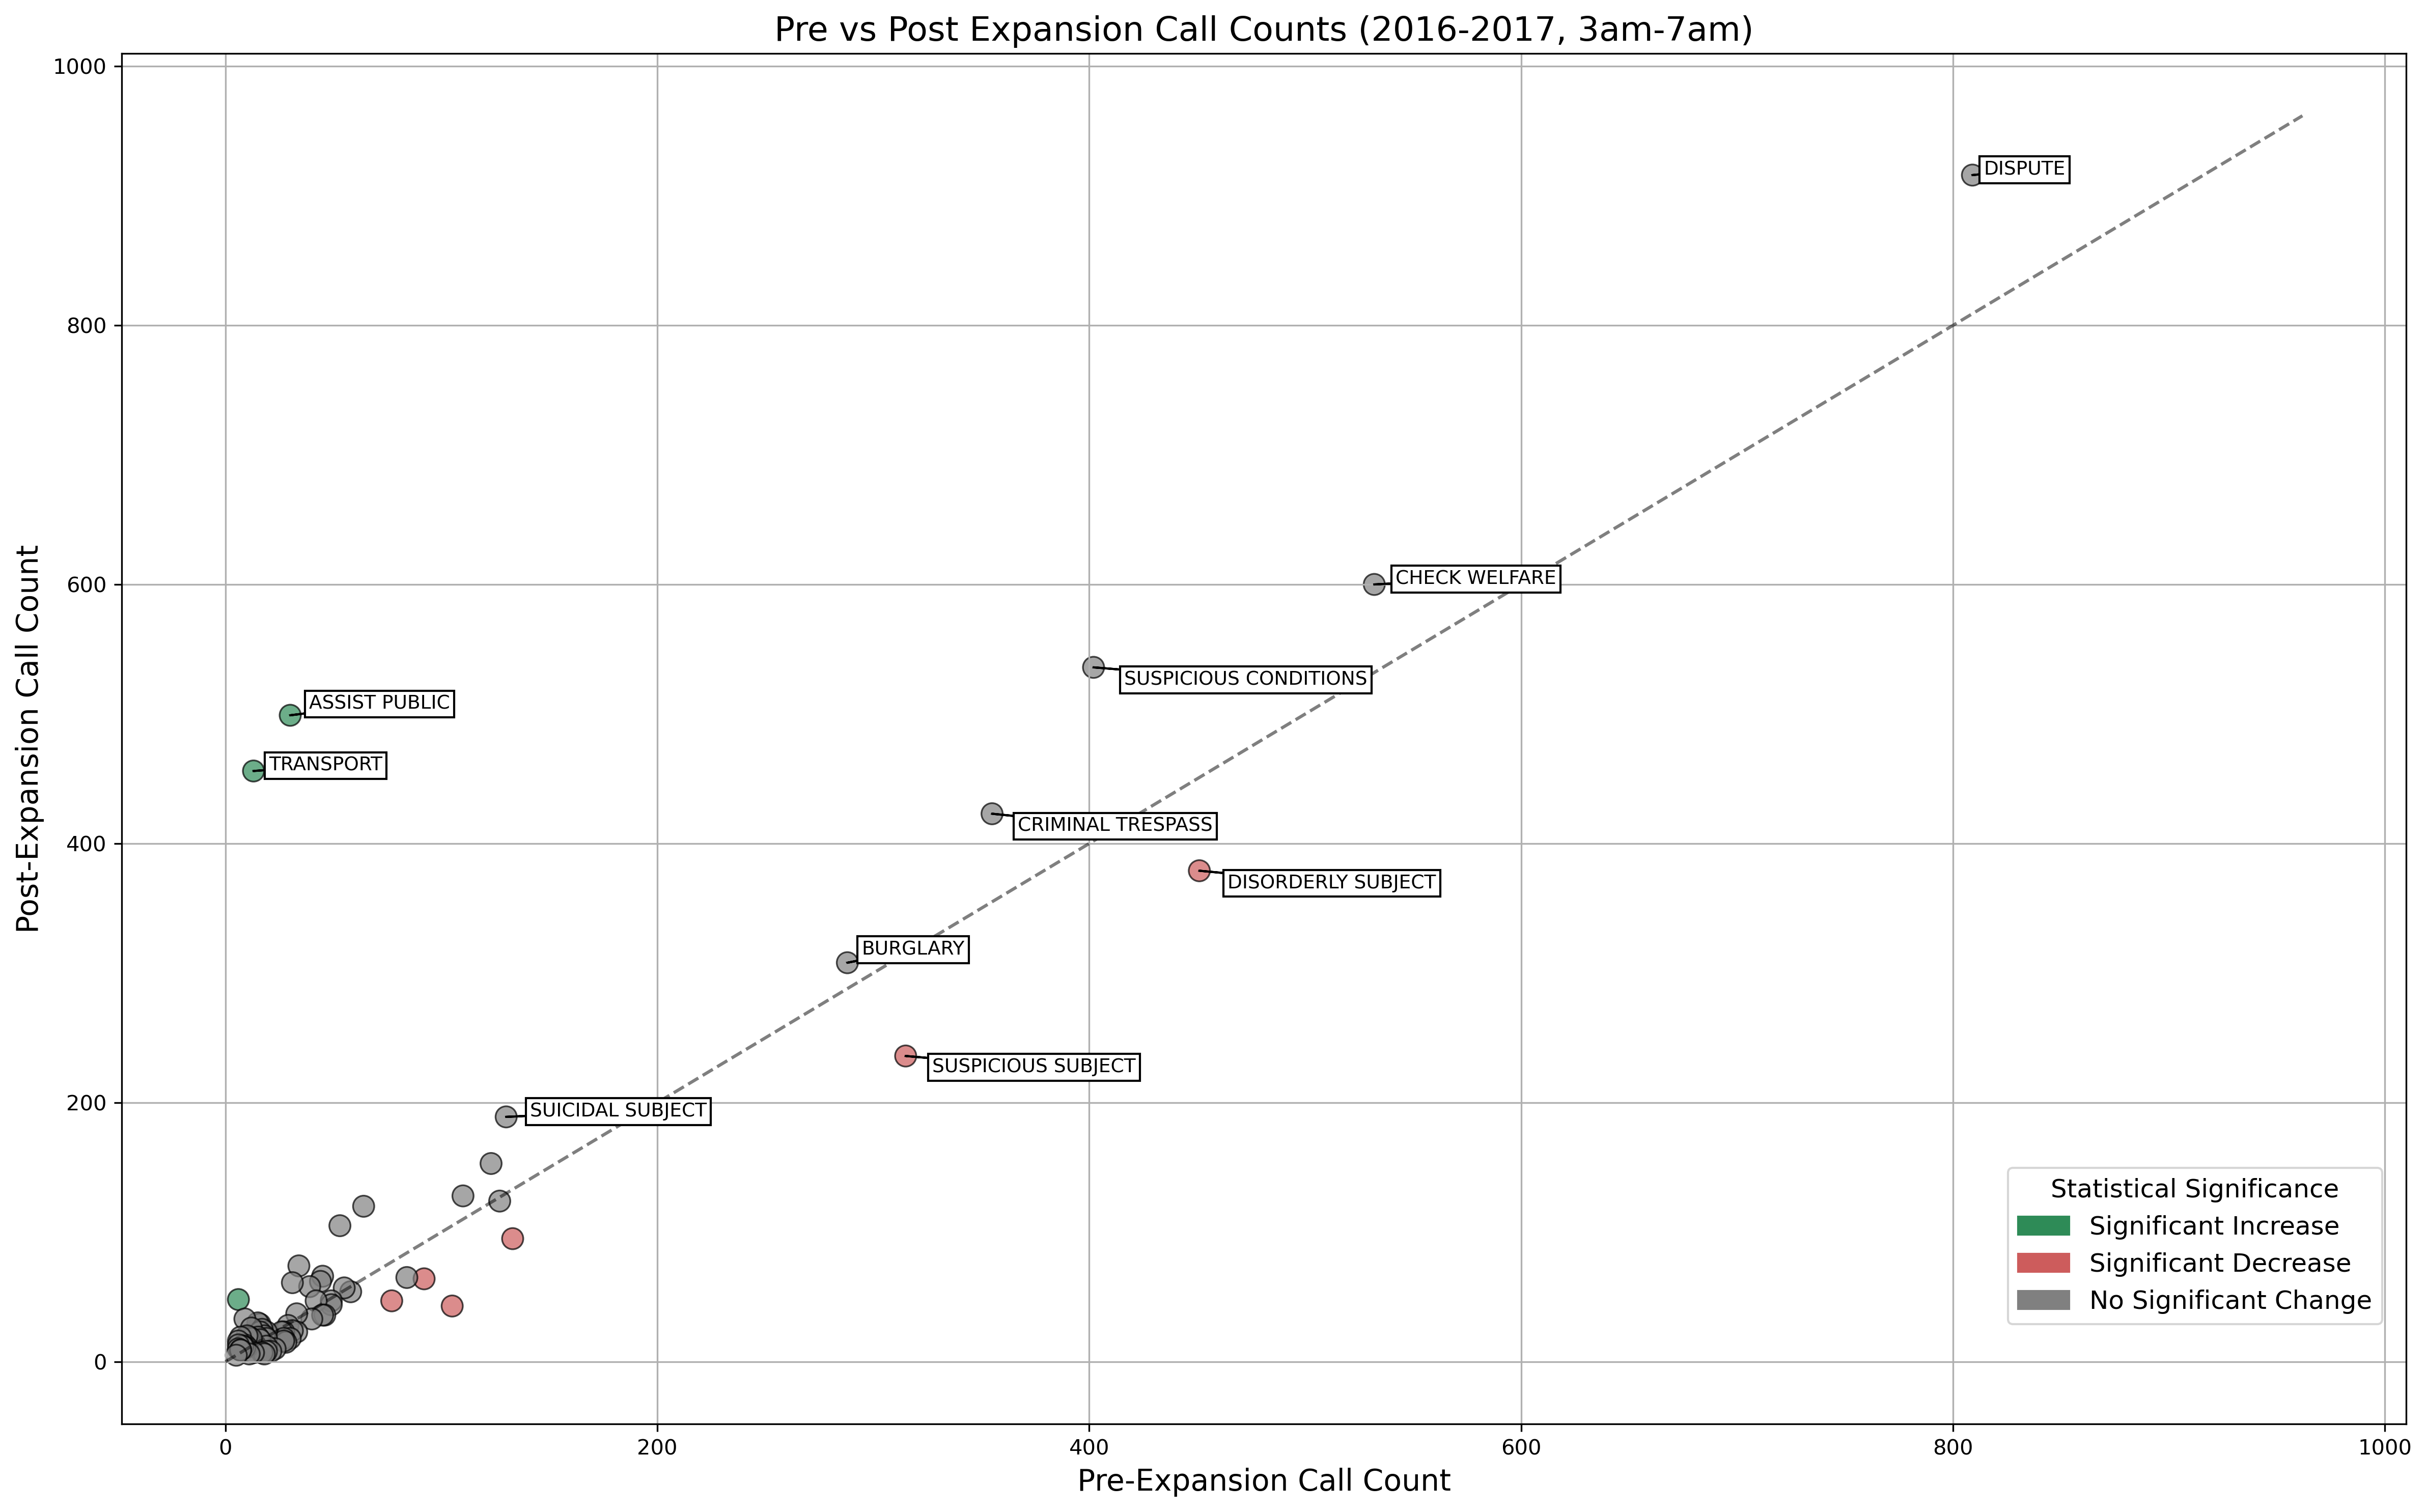

In [267]:
call_volume_comparison_16_17 = analyze_period(filtered_data, pre_year=2016, post_year=2017, min_count=5)

visualize_calls(
    call_volume_comparison_16_17,
    top_n=100,
    label_threshold=300,
    title='Pre vs Post Expansion Call Counts (2016-2017, 3am-7am)'
)

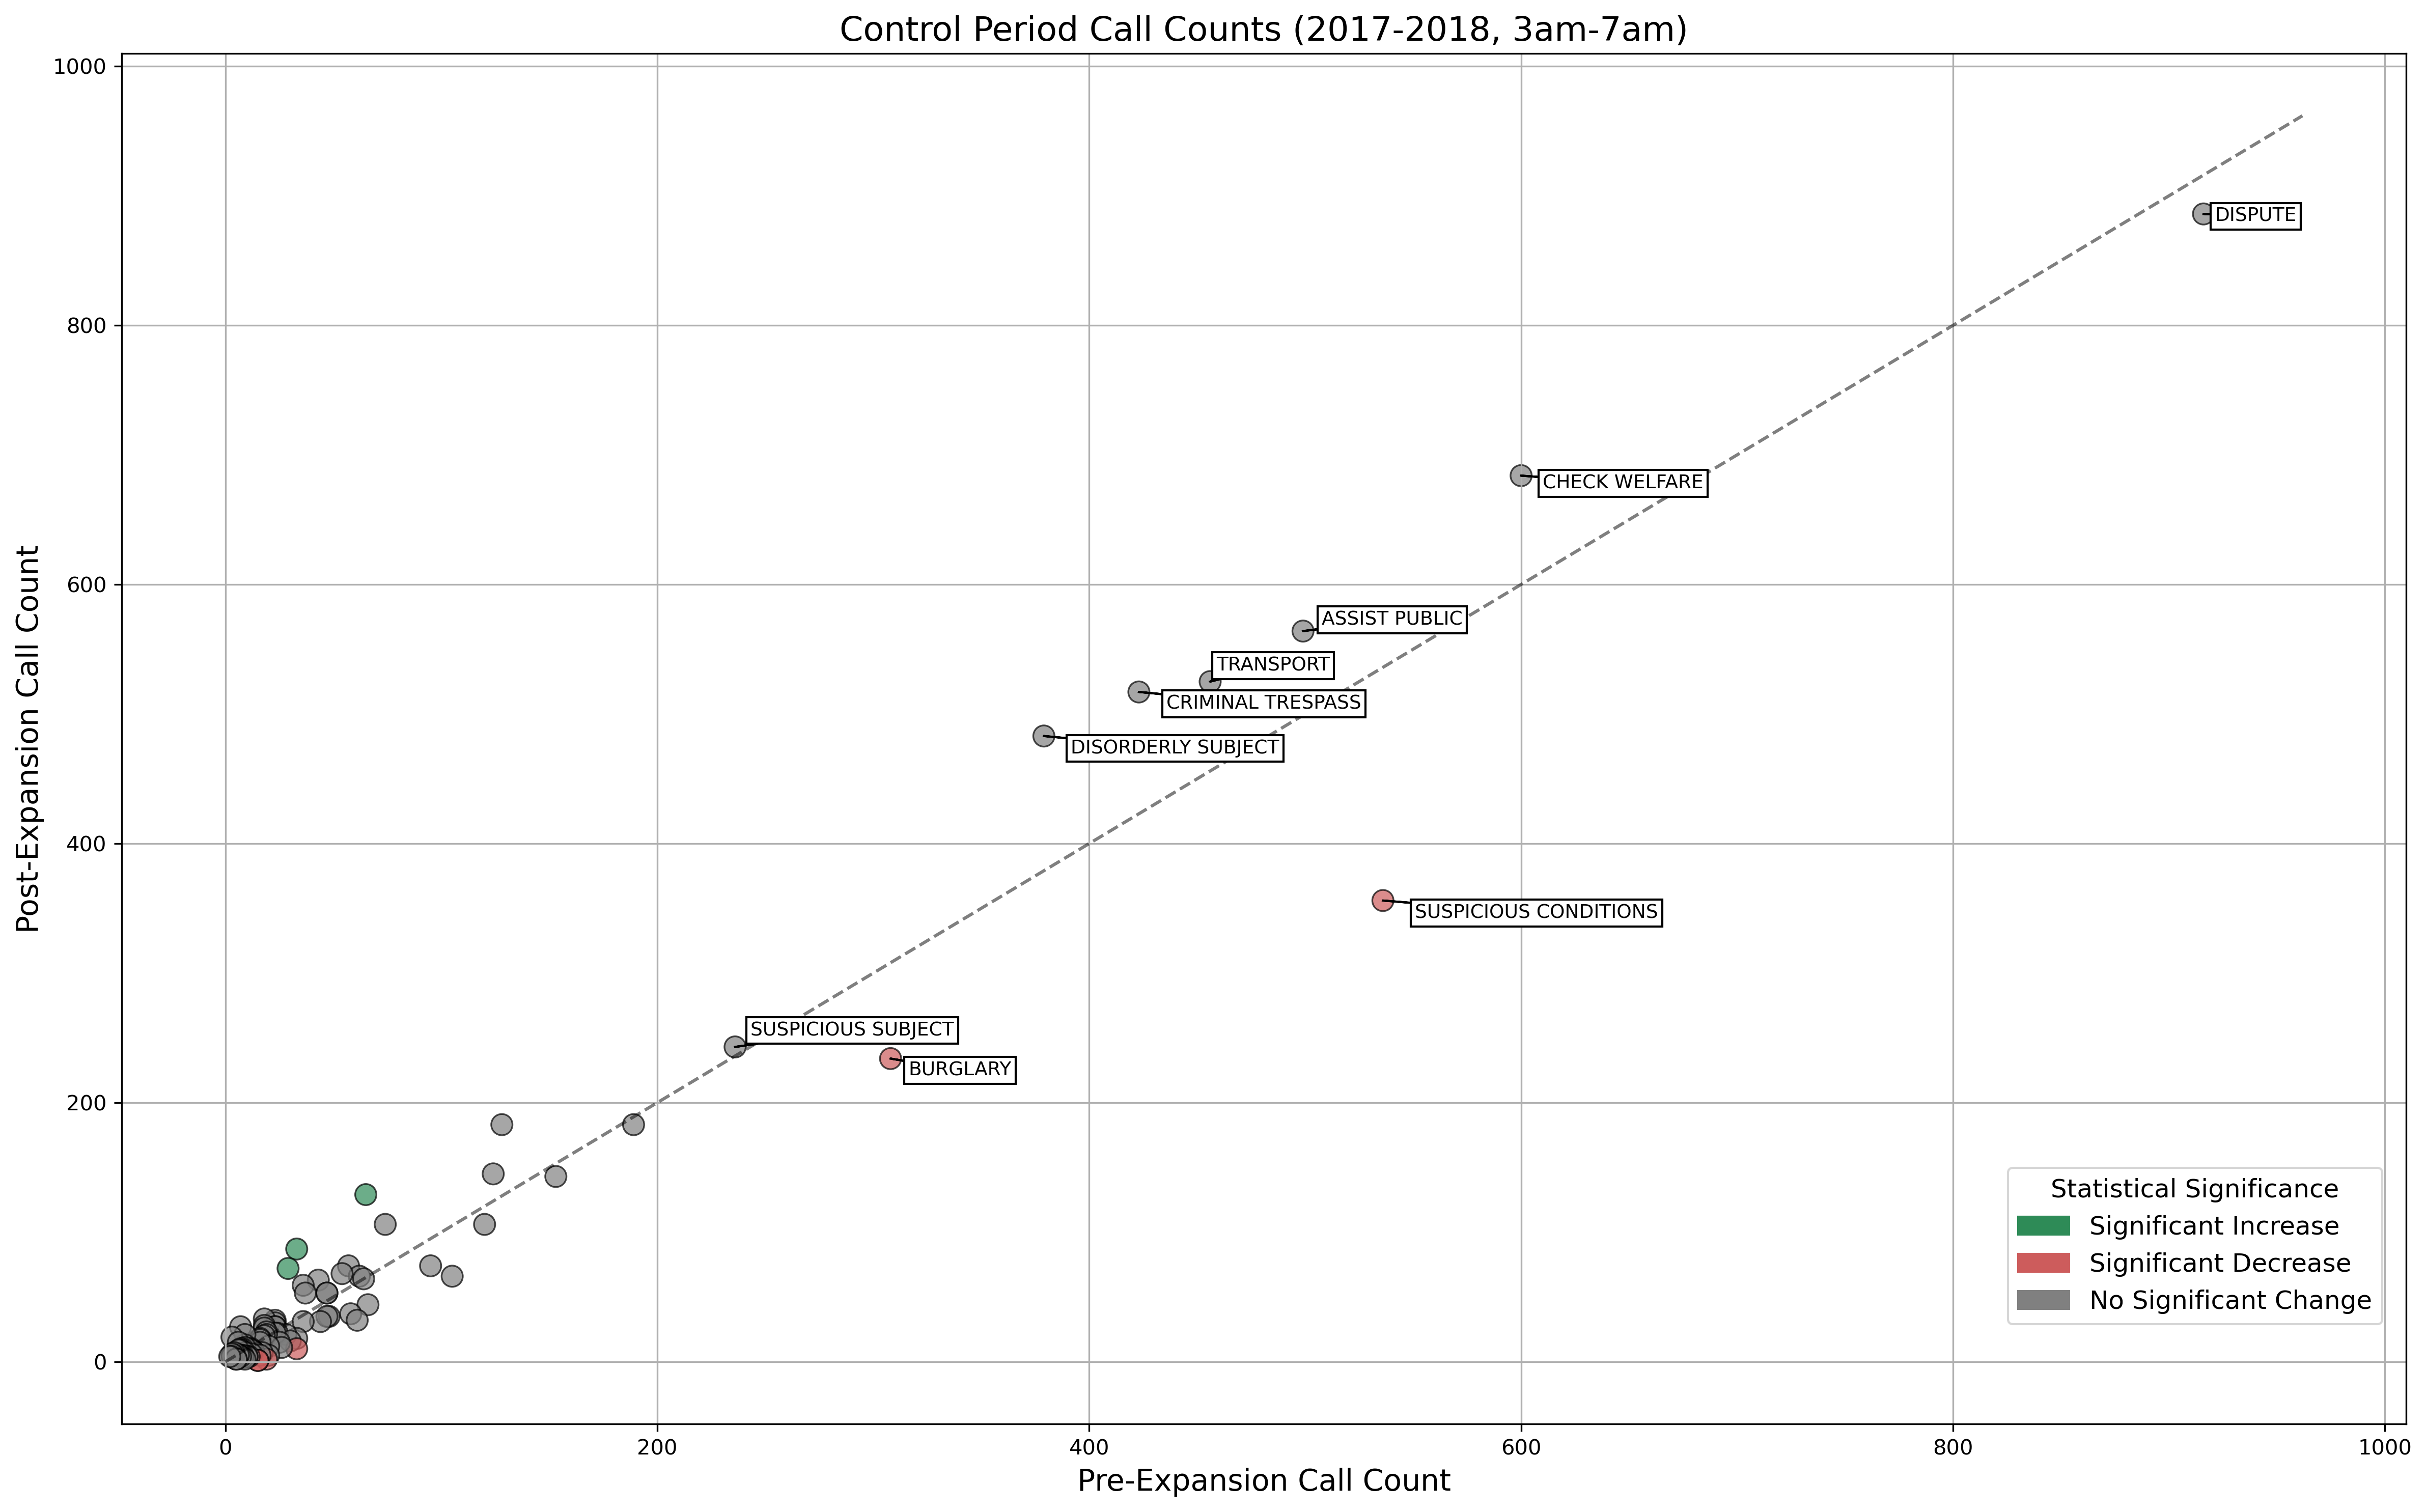

In [268]:
call_volume_comparison_17_18 = analyze_period(filtered_data, pre_year=2017, post_year=2018, min_count=0)

visualize_calls(
    call_volume_comparison_17_18,
    top_n=100,
    label_threshold=400,
    title='Control Period Call Counts (2017-2018, 3am-7am)'
)

In [269]:
cahoots_relevant_call_volume_comparison = call_volume_comparison_16_17[(call_volume_comparison_16_17["divertibility_classification"] == "Significant increase") &
                       (call_volume_comparison_16_17["cahoots_proportion"] > 0)].copy()

pd.concat([cahoots_relevant_call_volume_comparison.rename(columns={"InitialIncidentTypeDescription": "call_nature"}),
          call_volume_comparison_16_17[call_volume_comparison_16_17["InitialIncidentTypeDescription"] == 'CHECK WELFARE'].rename(columns={"InitialIncidentTypeDescription": "call_nature"})], ignore_index=True)[["call_nature", "pre_call_count", "post_call_count", "percentage_divertible", "p_value", "divertibility_classification"]]

,call_nature,pre_call_count,post_call_count,percentage_divertible,p_value,divertibility_classification
0,ASSIST PUBLIC,30,499.0,6.012024,1.425848e-92,Significant increase
1,FOUND SYRINGE,6,48.0,12.500000,2.497237e-07,Significant increase
2,TRANSPORT,13,456.0,2.850877,3.649257e-99,Significant increase
3,CHECK WELFARE,532,600.0,88.666667,6.950828e-02,No significant change


# Updated Diversion Rate based on Nat EXP

In [270]:
incidents = {
    "CHECK WELFARE": 0.1244, # 0.1244
    "DISPUTE": 0,
    "TRAFFIC HAZARD": 0,
    "SUBJECT SCREAMING": 0,
    "FOUND SYRINGE": 0.896,
    "ASSIST PUBLIC": 0.93805,
    "TRANSPORT":  0.98015
}

welfare_check = 6003  
public_assist = 5788  * (1-incidents["ASSIST PUBLIC"])
transport = 1803  * (1-incidents["TRANSPORT"])
suicidal_subject = 1571
disorderly_subject = 457
traffic_hazard = 372  * (1-incidents["TRAFFIC HAZARD"])
dispute = 255  * (1-incidents["DISPUTE"])
criminal_trespass = 230
intoxicated_subject = 219
found_syringe = 192  * (1-incidents["FOUND SYRINGE"])

# Found from CAD DATA
screaming_subject = 12 * (1-incidents["SUBJECT SCREAMING"])

# Adjusted for screaming subject
other = 1216 - 12

# Dispatched total police and cahoots
dispatched_total_cfs = 68427

adjusted_dispatched_cahoots = [welfare_check, public_assist, transport, suicidal_subject, disorderly_subject, traffic_hazard, dispute, criminal_trespass, intoxicated_subject, found_syringe, screaming_subject, other]

In [271]:
# sum of dispatched CAHOOTS calls after proportionally adjusting each relevant call type based on our natural experiment
sum(adjusted_dispatched_cahoots)

10737.32415

In [272]:
# Add welfare check adjustment
welfare_check = 6003  * (1-incidents["CHECK WELFARE"])
wc_adjusted_dispatched_cahoots = [welfare_check, public_assist, transport, suicidal_subject, disorderly_subject, traffic_hazard, dispute, criminal_trespass, intoxicated_subject, found_syringe, screaming_subject, other]
sum(wc_adjusted_dispatched_cahoots)

9990.55095

In [273]:
pre_adjust_sum = 6003+ 5788+ 1803+ 1571+ 457+ 372+ 255+ 230+ 219+ 192+ 12+ other

In [274]:
# Diversion Rate when accounting for WC
wc_corrected_diversion_rate = sum(wc_adjusted_dispatched_cahoots ) / (dispatched_total_cfs - (pre_adjust_sum - sum(wc_adjusted_dispatched_cahoots )))
wc_corrected_diversion_rate

0.1656490471996393

In [275]:
# Diversion rate adjusting only statistically significant call types
corrected_diversion_rate = sum(adjusted_dispatched_cahoots ) / (dispatched_total_cfs - (pre_adjust_sum - sum(adjusted_dispatched_cahoots )))
corrected_diversion_rate

0.17585356787097473